# Exploring Web Map Service (WMS)  

1. <a href="#helperFunctions">Helper Funcitons</a>
2. <a href="#mainLibs">WMS and OWSLib</a>
3. <a href="#serviceInfo">Getting some information about the service</a>
4. <a href="#basicGetMap">Getting the basic information we need to perform a GetMap request</a>
5. <a href="#advancedGetMap">More on GetMap request</a>
6. <a href="#ncWmsExtensions">TDS-ncWMS styles and extensions</a>
7. <a href="#wmsAndBasemap">WMS and basemap</a>

## 1. <a name="helperFunctions">Helper Functions</a>
 - Let's define a few helper functions to save and load images from a temporairy directory or url

In [1]:
# Function to get tmp image dir. If it does not exist, 
#  create it
def getTmpImgDir():
    from os import makedirs
    from os.path import exists, join
    tmp_img_dir = "tmp_img"
    if (not exists(tmp_img_dir)):
        makedirs(tmp_img_dir)
    return tmp_img_dir

#Function that saves the layer as an image
def saveLayerAsTmpImage(layer, inname):
    from os.path import join
    tmp_img_dir = getTmpImgDir()
    full_img_path = join(tmp_img_dir, inname)
    out = open(full_img_path, 'wb')
    out.write(layer.read())
    out.close()

# Function to load image
def loadTmpImage(image_name):
    from IPython.core.display import Image
    from os.path import join
    tmp_img_dir = getTmpImgDir()
    filename = join(tmp_img_dir, image_name)
    return Image(filename)

# Function to display image from a url
def loadRemoteImage(imgUrl):
    from IPython.core.display import Image
    return Image(url = imgUrl)

## 2. <a name="mainLibs">WMS and OWSLib</a>
- WMS is the Open Geospatial Consortium (OGC) standard interface for requesting georeferenced __images__ through HTTP.
- OWSLib is part of [geopython](http://geopython.github.io/), a GitHub organization comprised of Python projects related to geospatial. 
- OWSLib is a Python package for client programming with OGC Web Services (OWS) developed by [Tom Kralidis](http://www.kralidis.ca/).
- OWSLib supports several OGC standards: WFS, WCS, SOS...and of course WMS 1.1.1. [More](http://geopython.github.io/OWSLib/).  
- Does not come installed with canopy but is available in the community packages.
- Installation with enpkg:  
    * enpkg OWSLib
    * current version (07/09/2013) --> 0.4.0-1

## 3. <a name="serviceInfo">Getting some information about the service</a>  
  
* We will use OWSLib package and in particular the owslib.wms module.
* Within the TDS context, if WMS is enabled and set up in the catalogs, each dataset has a WMS url.
    

In [2]:
from owslib.wms import WebMapService
#We just need a WMS url from one TDS dataset...
serverurl ='http://weather.rsmas.miami.edu/thredds/wms/grib/NCEP/RAP/CONUS_13km/Best'
wms = WebMapService( serverurl, version='1.1.1')

The WebMapService object gets all the information available about the service through a GetCapabilities request:

In [3]:
#This is general information, common to all datasets in a TDS server
operations =[ op.name for op in  wms.operations ]
print('Available operations: ')
print(operations)

print('General information (common to all datasets):')
print(wms.identification.type)
print(wms.identification.abstract)
print(wms.identification.keywords)
print(wms.identification.version)
print(wms.identification.title)

Available operations: 
['GetCapabilities', 'GetMap', 'GetFeatureInfo']
General information (common to all datasets):
OGC:WMS
Scientific Data
['meteorology', 'atmosphere', 'climate', 'ocean', 'earth science']
1.1.1
IDD TDS


- Bounding boxes, styles and dimensions are specific to each layer.
- Each variable in a dataset translates into a layer in the WMS service. 
- Besides, the server creates virtual layers if it founds vector components in CF-1 or Grib conventions. 

In [4]:
#Listing all available layers...
layers = list(wms.contents)
for l in layers:
    print('Layer title: '+wms[l].title +', name:'+wms[l].name)

Layer title: Geopotential height @ Convective cloud top level, name:Geopotential_height_convective_cloud_top
Layer title: Convective inhibition @ Level at specified pressure difference from ground to level layer, name:Convective_inhibition_pressure_difference_layer
Layer title: v-component of wind @ Level at specified pressure difference from ground to level layer, name:v-component_of_wind_pressure_difference_layer
Layer title: Snow depth @ Ground or water surface, name:Snow_depth_surface
Layer title: u-component of wind @ Maximum wind level, name:u-component_of_wind_maximum_wind
Layer title: Temperature @ Specified height level above ground, name:Temperature_height_above_ground
Layer title: Water equivalent of accumulated snow depth (Mixed_intervals Accumulation) @ Ground or water surface, name:Water_equivalent_of_accumulated_snow_depth_surface_Mixed_intervals_Accumulation
Layer title: Categorical Ice Pellets @ Ground or water surface, name:Categorical_Ice_Pellets_surface
Layer title:

## 4. <a name="basicGetMap">Getting the basic information we need to perform a GetMap request</a>

-  All the information clients need is available in the capabilities document, which is stored in the WebMapService object.
-  TDS-WMS only supports GetMap requests on one layer (variable).
-  We need to choose our layer, bounding box, spatial reference system (SRS), size and format of the image.


In [5]:
#Values common to all GetMap requests: formats and http methods:
print(wms.getOperationByName('GetMap').formatOptions)
print(wms.getOperationByName('GetMap').methods)

#Let's choose: 'wind @ Isobaric surface' (the value in the parameter must be name of the layer)
wind = wms['wind @ Isobaric surface']

#What is its bounding box?
print(wind.boundingBox)

#available CRS
print(wind.crsOptions)
# --> NOT ALL THE AVAILABLE CRS OPTIONS ARE LISTED

['image/png', 'image/png;mode=32bit', 'image/gif', 'image/jpeg', 'application/vnd.google-earth.kmz']
[{'url': 'http://weather.rsmas.miami.edu/thredds/wms/grib/NCEP/RAP/CONUS_13km/Best', 'type': 'Get'}]
(-139.9699067110668, 16.20865486388938, -57.26853740515435, 55.51675688158025, 'EPSG:4326')
['CRS:84', 'EPSG:3857', 'EPSG:4326', 'EPSG:27700', 'EPSG:32761', 'EPSG:3408', 'EPSG:32661', 'EPSG:3409', 'EPSG:41001']


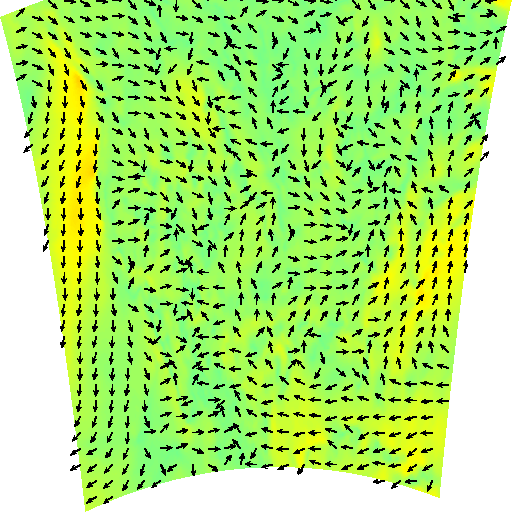

In [6]:
#let's get the image...    
img_wind = wms.getmap( layers=[wind.name], #only takes one layer
                  srs='EPSG:4326',
                  bbox=(wind.boundingBox[0],wind.boundingBox[1], wind.boundingBox[2], wind.boundingBox[3]),
                  size=(512, 512),
                  format='image/png'
)

#Save it..
saveLayerAsTmpImage(img_wind, 'test_wind.png')

#Display the image we've just saved...
loadTmpImage('test_wind.png')

# 5. <a name="advancedGetMap">More on GetMap requests</a>

* Handling time and vertical dimensions
* Changing styles
* Changing the spatial reference system (SRS)


### Handling time and vertical dimensions
* Getting available times for a layer:

In [7]:
#Times are available in the timepositions property of the layer
times= [time.strip() for time in wind.timepositions]
print(times)

['2015-06-10T00:00:00.000Z', '2015-06-10T01:00:00.000Z', '2015-06-10T02:00:00.000Z', '2015-06-10T03:00:00.000Z', '2015-06-10T04:00:00.000Z', '2015-06-10T05:00:00.000Z', '2015-06-10T06:00:00.000Z', '2015-06-10T07:00:00.000Z', '2015-06-10T08:00:00.000Z', '2015-06-10T09:00:00.000Z', '2015-06-10T10:00:00.000Z', '2015-06-10T11:00:00.000Z', '2015-06-10T12:00:00.000Z', '2015-06-10T13:00:00.000Z', '2015-06-10T14:00:00.000Z', '2015-06-10T15:00:00.000Z', '2015-06-10T16:00:00.000Z', '2015-06-10T17:00:00.000Z', '2015-06-10T18:00:00.000Z', '2015-06-10T19:00:00.000Z', '2015-06-10T20:00:00.000Z', '2015-06-10T21:00:00.000Z', '2015-06-10T22:00:00.000Z', '2015-06-10T23:00:00.000Z', '2015-06-11T00:00:00.000Z', '2015-06-11T01:00:00.000Z', '2015-06-11T02:00:00.000Z', '2015-06-11T03:00:00.000Z', '2015-06-11T04:00:00.000Z', '2015-06-11T05:00:00.000Z', '2015-06-11T06:00:00.000Z', '2015-06-11T07:00:00.000Z', '2015-06-11T08:00:00.000Z', '2015-06-11T09:00:00.000Z', '2015-06-11T10:00:00.000Z', '2015-06-11T11:00:0

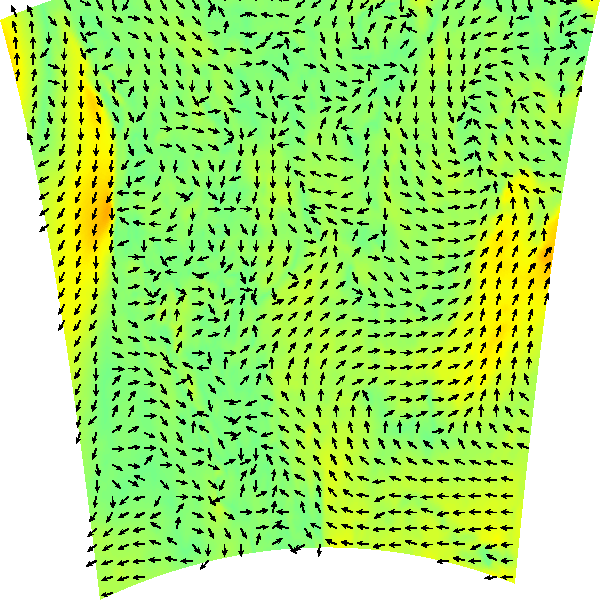

In [8]:
#We can choose any of the available times and make a request for it with the parameter time
#If no time is provided the default in TDS is the closest available time to the current time
img_wind = wms.getmap( layers=[wind.name], 
                  srs='EPSG:4326',
                  bbox=(wind.boundingBox[0],wind.boundingBox[1], wind.boundingBox[2], wind.boundingBox[3]),
                  size=(600, 600),
                  format='image/png',
                  time= times[len(times)-1]
)

saveLayerAsTmpImage(img_wind, 'test_wind.png')
loadTmpImage('test_wind.png')

In [12]:
#We can also specify a time interval to get an animated gif
#Format must be image/gif
img_wind = wms.getmap( layers=[wind.name], 
                  srs='EPSG:4326',
                  bbox=(wind.boundingBox[0],wind.boundingBox[1], wind.boundingBox[2], wind.boundingBox[3]),
                  size=(600, 600),
                  format='image/gif',
                  time= times[len(times)-4]+'/'+times[len(times)-1]
)

from IPython.core.display import Image
loadRemoteImage(img_wind.geturl())

* Getting the available vertical levels:  
OWSLib does not support vertical levels, meaning the layer objects do not have a property "elevations" with the vertical levels. So, we need a little extra work to get the available vertical levels for a layer

In [13]:
#Next version of OWSLib will support this...
#elevations = [el.strip() for el in wind.elevations]
#print elevations

#In the meantime...
def find_elevations_for_layer(wms, layer_name):
    """
        parses the wms capabilities document searching
        the elevation dimension for the layer
    """
    #Get all the layers
    levels =None;
    layers = wms._capabilities.findall(".//Layer")
    layer_tag = None
    for el in layers:
        name = el.find("Name")
        if name is not None and name.text.strip() == layer_name:
            layer_tag = el
            break        

    if layer_tag is not None:
        elevation_tag = layer_tag.find("Extent[@name='elevation']")
        if elevation_tag is not None:
            levels = elevation_tag.text.strip().split(',')

    return levels;

elevations = find_elevations_for_layer(wms, wind.name)
print(elevations)

['10000.0', '12500.0', '15000.0', '17500.0', '20000.0', '22500.0', '25000.0', '27500.0', '30000.0', '32500.0', '35000.0', '37500.0', '40000.0', '42500.0', '45000.0', '47500.0', '50000.0', '52500.0', '55000.0', '57500.0', '60000.0', '62500.0', '65000.0', '67500.0', '70000.0', '72500.0', '75000.0', '77500.0', '80000.0', '82500.0', '85000.0', '87500.0', '90000.0', '92500.0', '95000.0', '97500.0', '100000.0']


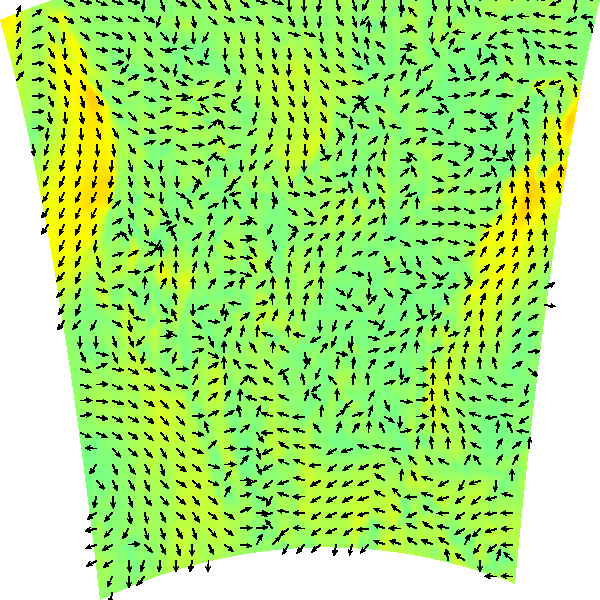

In [14]:
#now we can change our vertical level with the parameter elevation
#If no elevation parameter is provided the default is the first vertical level in the dimension.
img_wind = wms.getmap( layers=['wind @ Isobaric surface'], #only takes one layer
                  srs='EPSG:4326',
                  bbox=(wind.boundingBox[0],wind.boundingBox[1], wind.boundingBox[2], wind.boundingBox[3]),
                  size=(600, 600),
                  format='image/png',
                  time= times[0],
                  elevation=elevations[len(elevations)-1 ]
)

saveLayerAsTmpImage(img_wind, 'test_wind.png')
loadTmpImage('test_wind.png')

### Changing styles
* We can specify the style (any from the available styles for a layer) in the param styles

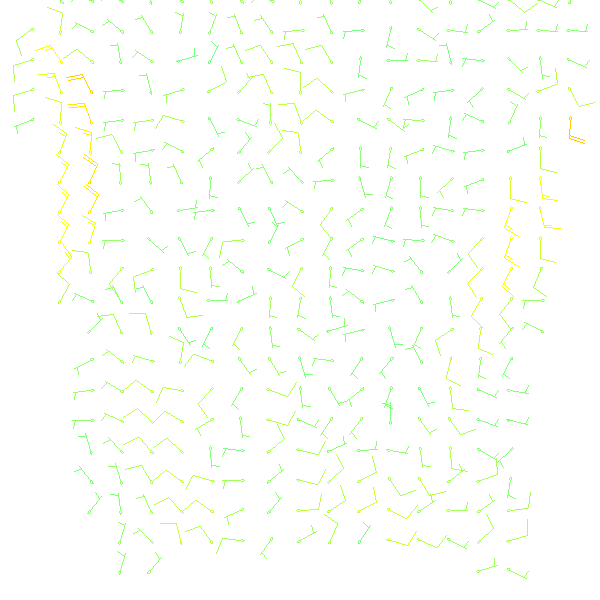

In [15]:
#available styles: 
#print wind.styles
#Change the style of our layer
img_wind = wms.getmap( layers=[wind.name], #only takes one layer
                  styles=['barb/rainbow'], #one style per layer    
                  srs='EPSG:4326',
                  bbox=(wind.boundingBox[0],wind.boundingBox[1], wind.boundingBox[2], wind.boundingBox[3]),
                  size=(600, 600),
                  format='image/png',
                  time= times[0]
)

saveLayerAsTmpImage(img_wind, 'test_wind_barb.png')
loadTmpImage('test_wind_barb.png')

### Changing the spatial reference system (SRS)
* We can reproject to any of the available SRS.

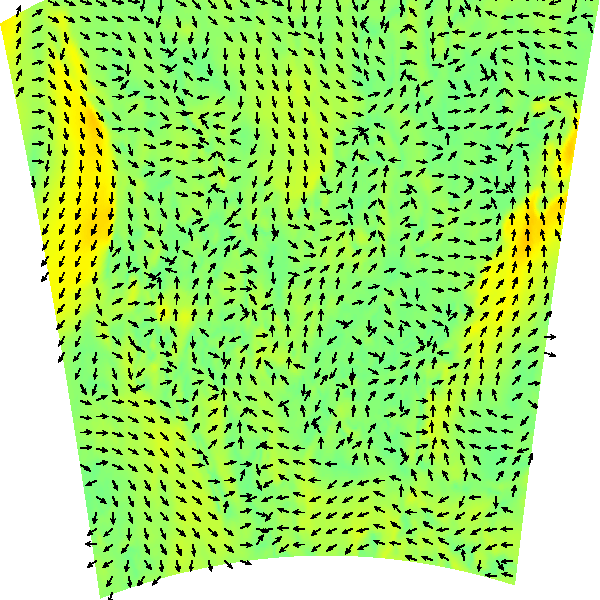

In [23]:
#Reproject the bounding box to a global mercator (EPSG:3875, projection used by Google Maps, OSM...) using cartopy
import cartopy.crs as ccrs
epsg = 3857
psproj = ccrs.epsg(epsg)
xmin, ymin = psproj.transform_point(wind.boundingBox[0], wind.boundingBox[1], ccrs.Geodetic())
xmax, ymax = psproj.transform_point(wind.boundingBox[2], wind.boundingBox[3], ccrs.Geodetic())
img_wind = wms.getmap( layers=[wind.name],
                  srs='EPSG:%d' % epsg,
                  bbox=(xmin, ymin, xmax, ymax),
                  size=(600, 600),
                  format='image/png',
                  time= times[0]
)

saveLayerAsTmpImage(img_wind, 'test_wind_3857.png')
loadTmpImage('test_wind_3857.png')

Cool, we already know how to make get map requests. Let's change our layer...

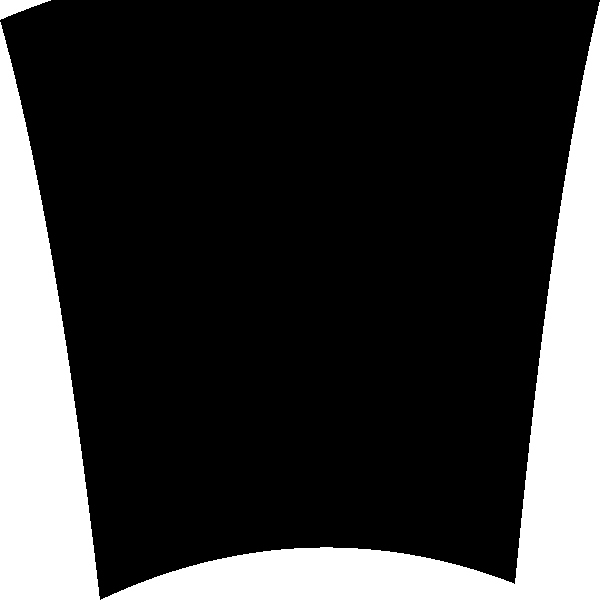

In [24]:
temp =wms['Temperature_isobaric']
img_temp = wms.getmap( layers=[temp.name], 
                  styles=['boxfill/rainbow'], 
                  srs='EPSG:4326',
                  bbox=(temp.boundingBox[0],temp.boundingBox[1], temp.boundingBox[2], temp.boundingBox[3]),
                  size=(600, 600),
                  format='image/png',
                  time= times[0]
)

saveLayerAsTmpImage(img_temp, 'test_temp.png')
loadTmpImage('test_temp.png')

...well not that cool.

## 6. <a name="ncWmsExtensions">TDS-ncWMS styles and extensions<a/>

* ncWMS/THREDDS provides some __[non-standard WMS parameters](http://www.resc.rdg.ac.uk/trac/ncWMS/wiki/WmsExtensions)__ that allow clients some control on the styling.

- Change the scale range: 
 - Default is -50,50. Parameter colorscalerange allows us to use a different scale  


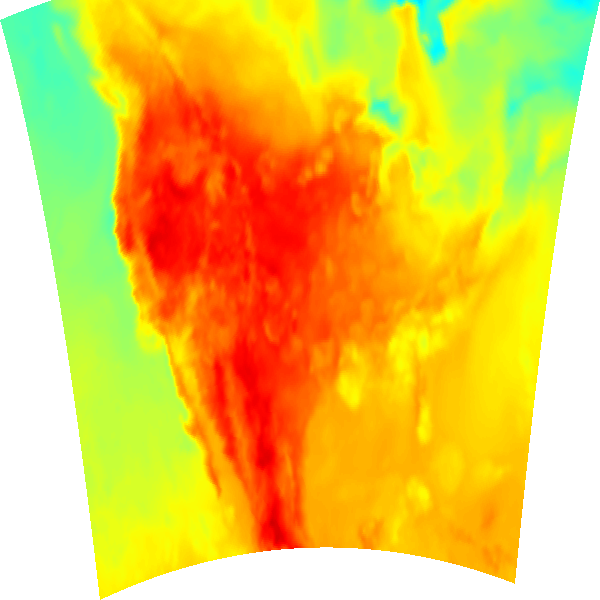

In [25]:
img_temp = wms.getmap( layers=[temp.name], 
                  styles=['boxfill/rainbow'], 
                  srs='EPSG:4326',
                  bbox=(wind.boundingBox[0],wind.boundingBox[1], wind.boundingBox[2], wind.boundingBox[3]),
                  size=(600, 600),
                  format='image/png',
                  time= times[0],
                  colorscalerange='250,320'
)

saveLayerAsTmpImage(img_temp, 'test_temp.png')
loadTmpImage('test_temp.png')

* abovemaxcolor, belowmincolor params give us control on how we want the values out of range to be displayed.
* valid values for those params are: extend (will use the highest/lowest value of the palette for values larger/smaller than the maximun/minimun), transparent and a color in 0xRRGGBB format

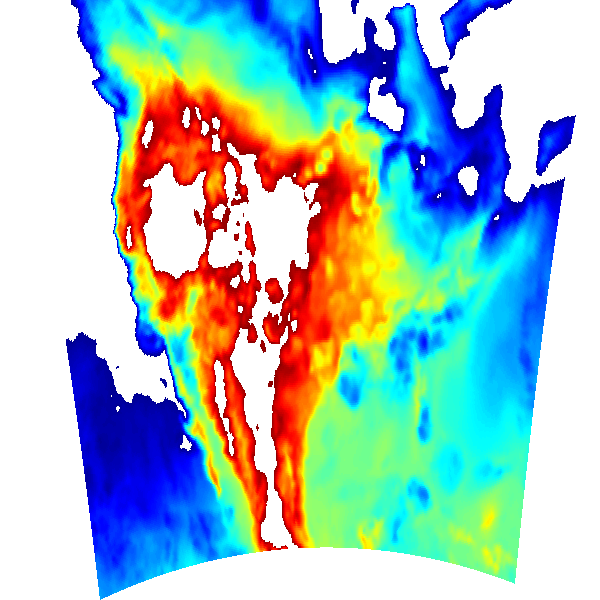

In [26]:
colorscalerange='290,310'

img_temp = wms.getmap( layers=[temp.name], 
                  styles=['boxfill/rainbow'], 
                  srs='EPSG:4326',
                  bbox=(wind.boundingBox[0],wind.boundingBox[1], wind.boundingBox[2], wind.boundingBox[3]),
                  size=(600, 600),
                  format='image/png',
                  time= times[0],
                  colorscalerange=colorscalerange,
                  abovemaxcolor='transparent',
                  belowmincolor='transparent'
)

saveLayerAsTmpImage(img_temp, 'test_temp.png')
loadTmpImage('test_temp.png')

The GetLegendGraphic request gives us a legend for the map, but the request is not supported by OWSLib.

In [27]:
params ={'request': 'GetLegendGraphic',
         'colorbaronly':'False', #want the text in the legend
         'layer':temp.name,
         'colorscalerange':colorscalerange}

legendUrl=serverurl+'?REQUEST={request:s}&COLORBARONLY={colorbaronly:s}&LAYER={layer:s}&COLORSCALERANGE={colorscalerange:s}'.format(**params)

loadRemoteImage(legendUrl)


## 7. <a name="wmsAndBasemap">WMS and basemap</a>  
We can use basemap to overlay the layer with a coastline...

In [29]:
import os
import urllib
import matplotlib.pyplot as plt
from matplotlib.offsetbox import AnnotationBbox, OffsetImage
from matplotlib._png import read_png

%matplotlib inline

m = Basemap(llcrnrlon=temp.boundingBox[0], llcrnrlat=temp.boundingBox[1],
            urcrnrlon=temp.boundingBox[2], urcrnrlat=temp.boundingBox[3]+5.0,
            resolution='l',epsg=4326)

plt.figure(1, figsize=(16,12))
plt.title(temp.title +' '+times[0] )

m.wmsimage(serverurl,xpixels=600, ypixels=600, verbose=False,
        layers=[temp.name], 
        styles=['boxfill/rainbow'], 
        time= times[0],
        colorscalerange=colorscalerange,
        abovemaxcolor='extend',
        belowmincolor='transparent'
)

m.drawcoastlines(linewidth=0.25)

#Annotating the map with the legend
#Save the legend as image
cwd = os.getcwd()
legend = urllib.request.urlopen(legendUrl)
saveLayerAsTmpImage(legend, 'legend_temp.png')

#read the image as an array
arr = read_png(os.path.join(getTmpImgDir(),'legend_temp.png'))
imagebox = OffsetImage(arr, zoom=0.7)
xy =[ temp.boundingBox[2], temp.boundingBox[1] ]

#Gets the current axis
ax = plt.gca()

#Creates the annotation
ab = AnnotationBbox(imagebox, xy,
                    xybox=(-46.,100.),
                    xycoords='data',
                    boxcoords="offset points",
                    pad=0.)

#Adds the legend image as an AnnotationBbox to the map
ax.add_artist(ab)

plt.show()

NameError: name 'Basemap' is not defined

##Exercise:
- Get the vertical levels for the layer temp.
- Change the request for getting the highest level.
- Change the color scale range to appropriate values.